# Setup

In [3]:
%load_ext autoreload
%autoreload 2
%aimport

%matplotlib inline 

import torch
import matplotlib.pyplot as plt
from einops import rearrange

from bliss.catalog import TileCatalog, get_images_in_tiles
from bliss.encoder import Encoder


device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:

3


# Load models

In [4]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate

with initialize(config_path="../../coadds/config"):
    cfg = compose("config", overrides=[])

In [5]:
location = instantiate(cfg.models.detection_encoder).to(device).eval()
# NOTE: change weight_checkpoint to the one in your output folder
location.load_state_dict(torch.load('../output/encoder.pt', map_location=location.device)
)

encoder = Encoder(location.eval(), n_images_per_batch=10, n_rows_per_batch=15).to(device).eval()

In [6]:
location_coadd = instantiate(cfg.models.detection_encoder).to(device).eval()
location_coadd.load_state_dict(torch.load('../output/coadd_encoder.pt', map_location=location_coadd.device)
)

encoder_coadd = Encoder(location_coadd.eval(), n_images_per_batch=10, n_rows_per_batch=15).to(device).eval()

In [7]:
# location_coadd = instantiate(cfg.models.detection_encoder).to(device).eval()
# location.load_state_dict(torch.load('../../coadds/models/coadd_encoder_2.pt', map_location=location.device)
# )

# encoder_coadd_25 = Encoder(location.eval(), n_images_per_batch=10, n_rows_per_batch=15).to(device)

# Load datasets

## Coadd dataset with N_dithers = 10

In [8]:
with initialize(config_path="../config"):
    cfg = compose("config", overrides=[])

In [9]:
# should be ONLY stars
cfg.datasets.galsim_blends_coadds.prior.galaxy_prob

0.0

In [10]:
cfg.datasets.galsim_blends_coadds.prior.n_dithers

10

In [31]:
ds = instantiate(cfg.datasets.galsim_blends_coadds, batch_size=64, n_batches=100, num_workers=20)

In [32]:
from bliss.generate import generate
generate(ds, '../output/coadd_dataset2.pt', '../output/coadd_dataset2.png', 9, global_params=("background",))


Generating dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:45<00:00,  2.21it/s]


# Run model on saved dataset

In [11]:
sds = torch.load('../output/coadd_dataset2.pt')
sds['images'].shape, sds['noisy'].shape, sds['n_sources'].shape

(torch.Size([6400, 1, 88, 88]),
 torch.Size([6400, 1, 88, 88]),
 torch.Size([6400, 10, 10]))

In [12]:
# keys of dataset
sds.keys()

dict_keys(['images', 'noisy', 'background', 'n_sources', 'locs', 'galaxy_bools', 'star_bools', 'galaxy_params', 'star_fluxes', 'star_log_fluxes'])

In [13]:
# parameters saved are on tiles
sds['locs'].shape

torch.Size([6400, 10, 10, 1, 2])

In [14]:
# format background (needs to be CONSTANT)
n_batches = sds['images'].shape[0]
slen = sds['images'].shape[-1]
background = rearrange(sds['background'], '1 h w -> 1 1 h w')
background = background.expand(n_batches, 1, slen, slen)

In [15]:
# run (single-exposure) model prediction 
tile_est = encoder.variational_mode(sds['noisy'], background)

Encoding ptiles: 640it [00:27, 23.25it/s]


In [15]:
# run (coadd) model prediction 
tile_est_coadd = encoder_coadd.variational_mode(sds['images'], background)

Encoding ptiles: 640it [00:20, 30.77it/s]


In [16]:
# run (coadd) model prediction 
# tile_est_coadd_25 = encoder_coadd_25.variational_mode(sds['noisy'], background)

# Metrics on prediction compared to truth

In [16]:
# load true catalog
catalog_dict = {
    "locs": sds["locs"],
    "star_log_fluxes": sds["star_log_fluxes"],
    "galaxy_bools": sds["galaxy_bools"],
    "n_sources": sds["n_sources"],
    "star_fluxes": sds['star_fluxes']
}

In [17]:
true_tile_catalog = TileCatalog(4, catalog_dict)
truth = true_tile_catalog.to_full_params()

# Encoder

## Get Full Catalogs

In [18]:
est = tile_est.cpu().to_full_params() # full estimated catalog from single exposure model

In [19]:
# parameters are now per image
est.plocs.shape

torch.Size([6400, 8, 2])

In [20]:
est['galaxy_bools'] = torch.zeros(est.batch_size, est.max_sources, 1) # only stars, did not train classification encoder

## Simple metrics

In [21]:
# encoder
from bliss.reporting import DetectionMetrics
metrics = DetectionMetrics()(truth, est)

In [22]:
metrics['f1'], metrics['precision'], metrics['recall']

(tensor(0.8763), tensor(0.9287), tensor(0.8295))

In [23]:
print(truth.n_sources)
print(est.n_sources)

tensor([4, 1, 3,  ..., 4, 6, 5])
tensor([3, 1, 3,  ..., 2, 5, 5])


In [ ]:
# encoder coadd

## Flux prediction

In [71]:
from bliss.reporting import match_by_locs

In [70]:
# encoder
true_plocs = truth.plocs
est_plocs = est.plocs

In [79]:
# obtain fluxes of matches
true_fluxes = []
est_fluxes = [] 
for ii in range(true_plocs.shape[0]):
    n_sources1, n_sources2 = truth.n_sources[ii].item(), est.n_sources[ii].item()
    if n_sources1 > 0 and n_sources2 > 0:
        plocs1 = true_plocs[ii]
        plocs2 = est_plocs[ii]
        mtrue, mest, dkeep, avg_distance = match_by_locs(plocs1, plocs2)
        tp = len(plocs2[mest][dkeep])  # n_matches
        
        fluxes1 = truth['star_fluxes'][ii][mtrue][dkeep]
        fluxes2 = est['star_fluxes'][ii][mest][dkeep]
        for jj in range(tp):
            flux1 = fluxes1[jj].item()
            flux2 = fluxes2[jj].item()
            assert flux1 > 0 and flux2 > 0
            true_fluxes.append(flux1)
            est_fluxes.append(flux2)

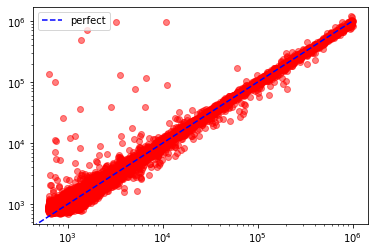

In [87]:
plt.scatter(true_fluxes, est_fluxes, marker='o', color='r', alpha=0.5)
plt.plot([0, 1e6], [0, 1e6], 'b--', label='perfect')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [ ]:
# good idea might be to plot median and quartiles of the red points in buckets of truth?

## Add magnitude to truth and estimated catalog

In [24]:
# NOTE: need to add 'mag' to catalog
# ASSUMES only stars
from bliss.datasets.sdss import convert_flux_to_mag
truth['mags'] = torch.zeros_like(truth['star_fluxes'])
for ii in range(len(truth.n_sources)):
    n_sources = truth.n_sources[ii].item()
    truth['mags'][ii, :n_sources] = convert_flux_to_mag(truth['star_fluxes'][ii, :n_sources])

In [25]:
# NOTE: need to add 'mag' to catalog
# ASSUMES only stars
from bliss.datasets.sdss import convert_flux_to_mag
est['mags'] = torch.zeros_like(est['star_fluxes'])
for ii in range(len(est.n_sources)):
    n_sources = est.n_sources[ii].item()
    est['mags'][ii, :n_sources] = convert_flux_to_mag(est['star_fluxes'][ii, :n_sources])

## Check apply mag bin works

In [37]:
from collections import defaultdict
count_b = defaultdict(int)  # count occurences in batch
print(count_b[0])
count_b[0] += 1 
count_b[0]

0


1

In [51]:
# check our function works!!?
_truth = truth.apply_param_bin('mags', 21, 25)

In [52]:
truth['mags'].squeeze()

tensor([[22.3879, 22.8570, 22.2323, 21.0521,  0.0000,  0.0000],
        [20.2752,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [22.2487, 19.5548, 21.1386,  0.0000,  0.0000,  0.0000],
        ...,
        [21.8143, 16.5837, 21.5527, 20.9318,  0.0000,  0.0000],
        [16.3188, 21.2247, 22.5964, 21.2340, 22.4575, 22.5583],
        [22.5848, 20.3566, 21.2475, 19.1546, 21.2439,  0.0000]])

In [53]:
_truth['mags'].squeeze()

tensor([[22.3879, 22.8570, 22.2323, 21.0521,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [22.2487, 21.1386,  0.0000,  0.0000,  0.0000,  0.0000],
        ...,
        [21.8143, 21.5527,  0.0000,  0.0000,  0.0000,  0.0000],
        [21.2247, 22.5964, 21.2340, 22.4575, 22.5583,  0.0000],
        [22.5848, 21.2475, 21.2439,  0.0000,  0.0000,  0.0000]])

In [54]:
truth.n_sources

tensor([4, 1, 3,  ..., 4, 6, 5])

In [55]:
_truth.n_sources

tensor([4, 0, 2,  ..., 2, 5, 3])

In [88]:
# seems to work!

## get metrics per magnitude bin

In [173]:
# first check scene_metrics works for one bin 
from bliss.reporting import scene_metrics

In [174]:
results = scene_metrics(truth, est, mag_min=-np.inf, mag_max=18)

In [215]:
from tqdm import tqdm
from collections import defaultdict
from case_studies.sdss_galaxies.plots.bliss_figures import set_rc_params, format_plot, CB_color_cycle
def compute_mag_bin_metrics(mag_bins, truth, pred):
    metrics_per_mag = defaultdict(lambda: torch.zeros(len(mag_bins)))

    # compute data for precision/recall/classification accuracy as a function of magnitude.
    for ii, (mag1, mag2) in tqdm(enumerate(mag_bins), total=len(mag_bins)):
        res = scene_metrics(truth, pred, mag_min=mag1, mag_max=mag2, slack=1.0)
        metrics_per_mag["precision"][ii] = res["precision"]
        metrics_per_mag["recall"][ii] = res["recall"]
        metrics_per_mag["f1"][ii] = res["f1"]
        metrics_per_mag["class_acc"][ii] = res["class_acc"]
        conf_matrix = res["conf_matrix"]
        metrics_per_mag["galaxy_acc"][ii] = conf_matrix[0, 0] / conf_matrix[0, :].sum().item()
        metrics_per_mag["star_acc"][ii] = conf_matrix[1, 1] / conf_matrix[1, :].sum().item()
        for k, v in res["counts"].items():
            metrics_per_mag[k][ii] = v

    return dict(metrics_per_mag)


def make_detection_figure(
    mags,
    data,
    xlims=(18, 24),
    ylims=(0.5, 1.05),
    ratio=2,
    where_step="mid",
    n_gap=50,
):
    # precision / recall / f1 score
    precision = data["precision"].numpy()
    recall = data["recall"].numpy()
    f1_score = data["f1"].numpy()
    tgcount = data["tgcount"].numpy()
    tscount = data["tscount"].numpy()
    egcount = data["egcount"].numpy()
    escount = data["escount"].numpy()
    # (1) precision / recall
    set_rc_params(tick_label_size=22, label_size=30)
    fig, (ax1, ax2) = plt.subplots(
        2, 1, figsize=(10, 10), gridspec_kw={"height_ratios": [1, ratio]}, sharex=True
    )
    
    ymin = min(min(precision), min(recall))
    yticks = np.arange(np.round(ymin, 1), 1.1, 0.1)
    format_plot(ax2, xlabel=r"\rm magnitude cut", ylabel="metric", yticks=yticks)
    ax2.plot(mags[:, 1], recall, "-o", label=r"\rm recall")
    ax2.plot(mags[:, 1], precision, "-o", label=r"\rm precision")
    ax2.plot(mags[:, 1], f1_score, "-o", label=r"\rm f1 score")
    ax2.legend(loc="lower left", prop={"size": 22})
    ax2.set_xlim(xlims)
    ax2.set_ylim(ylims)

    # setup histogram plot up top.
    c1 = CB_color_cycle[3]
    c2 = CB_color_cycle[4]
    ax1.step(mags[:, 1], tscount, label="truth stars", where=where_step, color=c2)
    ax1.step(mags[:, 1], escount, label="pred. stars", ls="--", where=where_step, color=c2)
  
    ymax = max(max(tgcount), max(tscount), max(egcount), max(escount))
#     ymax = np.ceil(ymax / n_gap) * n_gap
#     yticks = np.arange(0, ymax, n_gap)
    ax1.set_ylim((0, ymax*1.2))
#     format_plot(ax1, yticks=yticks, ylabel=r"\rm Counts")
    format_plot(ax1, ylabel=r"\rm Counts")
    ax1.legend(loc="best", prop={"size": 16})
    plt.subplots_adjust(hspace=0)
    return fig

In [209]:
mag_cuts

tensor([[   -inf, 17.5000],
        [   -inf, 18.0000],
        [   -inf, 18.5000],
        [   -inf, 19.0000],
        [   -inf, 19.5000],
        [   -inf, 20.0000],
        [   -inf, 20.5000],
        [   -inf, 21.0000],
        [   -inf, 21.5000],
        [   -inf, 22.0000],
        [   -inf, 22.5000],
        [   -inf, 23.0000],
        [   -inf, 23.5000],
        [   -inf, 24.0000]])

In [210]:
mag_cuts2 = torch.arange(17.5, 23.5, 0.5)
mag_cuts1 = torch.full_like(mag_cuts2, fill_value=-np.inf)
mag_cuts = torch.column_stack((mag_cuts1, mag_cuts2))

In [211]:
# data = compute_mag_bin_metrics(mag_cuts, truth, est)

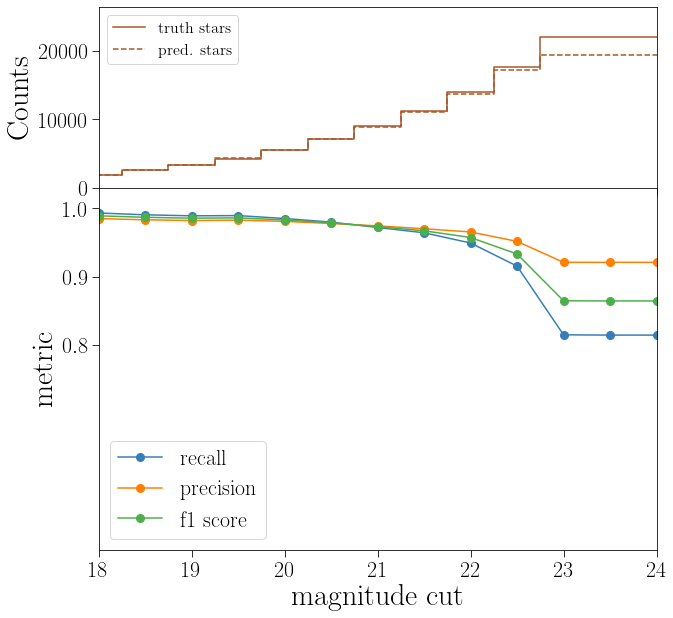

In [216]:
fig = make_detection_figure(mag_cuts, data, ylims=(0.5, 1.03), n_gap=10)

In [219]:
est['mags'].max()

tensor(22.9927)

# Coadd decoder

In [25]:
## Get Full Catalogs

est_coadd = tile_est_coadd.cpu().to_full_params() # full estimated catalog from single exposure model

# parameters are now per image
est_coadd.plocs.shape

est_coadd['galaxy_bools'] = torch.zeros(est.batch_size, est.max_sources, 1) # only stars, did not train classification encoder



In [26]:
## Simple metrics

# encoder
from bliss.reporting import DetectionMetrics
metrics = DetectionMetrics()(truth, est_coadd)

In [27]:
metrics['f1'], metrics['precision'], metrics['recall']

(tensor(0.9446), tensor(0.9544), tensor(0.9350))

In [28]:
print(truth.n_sources)
print(est.n_sources)

tensor([4, 1, 3,  ..., 4, 6, 5])
tensor([3, 1, 3,  ..., 2, 5, 5])
